In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
from math import log

## Original Model

In [2]:
beta = 0.01
k = 4
e = 0.05
size = 50
N = size**2
#T = int(log(N, R))\
T = 2000

In [50]:
counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,4):
    counts[i].append(0)

for t in tqdm(range(T)):
    inf = sum(sum(counts.get(i)) for i in counts.keys())
    for i in range(4):
        new = (beta * (1 - inf) *((1-e)**2*sum(counts.get(i)) + e*(1-e)*sum(counts.get((i+1) % 4)) + 
                                   e*(1-e)*sum(counts.get((i-1) % 4)) + e**2*sum(counts.get((i-2) % 4))))
        counts[i].append(new)

  0%|          | 0/2000 [00:00<?, ?it/s]

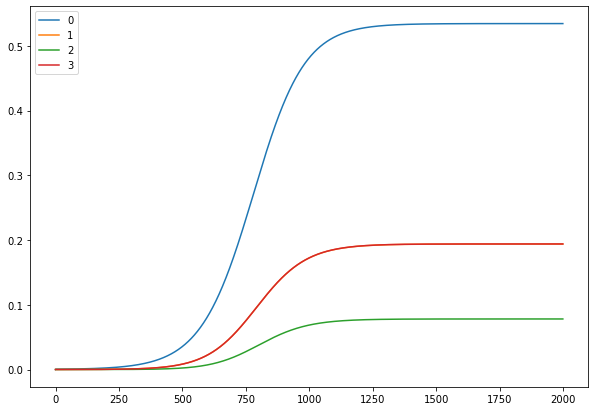

In [51]:
fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), [sum(counts.get(i)[:t]) for t in range(T)], label=f"{i}")
             
plt.legend()
plt.savefig('SI_w_error_2bit_0.05.pdf')

## Matrix-Based Model

In [67]:
beta = 1/1000
k = 4
e = 0.15
size = 50
N = size**2
#T = int(log(N, R))\
T = 3500

In [68]:
# (this is the two rotation version) B = np.array([(1-e)**2, e*(1-e), e**2, e*(1-e) ])
B = np.array([(1-e), e, 0, e ])

In [69]:
counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,4):
    
    counts[i].append(0)
    
for t in tqdm(range(1,T)):
    
    I = np.array([[counts.get(x)[-1]] for x in counts.keys()], dtype=object)
    
    new = np.zeros((4,1))
    
    for x in counts.keys():
        Ir = np.concatenate([I[x:],I[:x]]) # permuting the vector 
        
        di = beta * k * (1 - np.sum(I)) * np.matmul(B, Ir)
        
        new[x,0] = di
    
    It = I+new
    for x in counts.keys():
        counts[x].append(It[x][0])

  0%|          | 0/3499 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction Infected with Strain $x$ ($i_x$)')

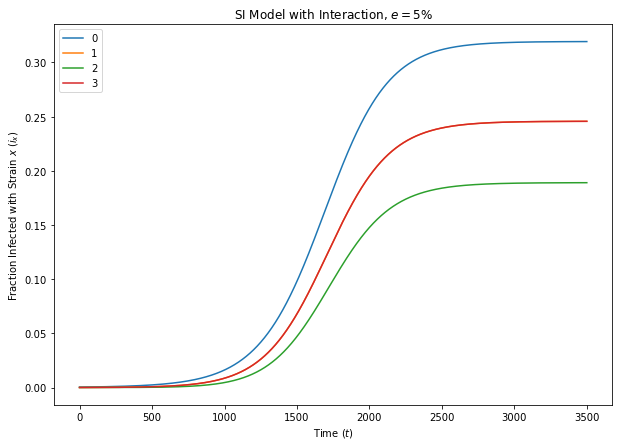

In [70]:
fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), counts.get(i), label=f"{i}")
             
plt.legend()

plt.title(r'SI Model with Interaction, $e=5\%$')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Fraction Infected with Strain $x$ ($i_x$)')
#plt.savefig('SI_error_100.pdf')

## Generalize to all rotational errors

In [78]:
def ssi(
    B,
    beta = 1/1000,
    k = 4,
    e = 0.5,
    N = 50**2,
    T = 3500,
    bar = True
):
    
    # Add annotations in PyCharm
    
    cts = defaultdict(list)

    cts[0].append(1/N)
    

    for i in range(1,4):

        cts[i].append(0)
    
    if bar:
        pbar = tqdm(range(1,T))
    else:
        pbar = range(1,T)
    
        
    for t in pbar:

        I = np.array([[cts.get(x)[-1]] for x in cts.keys()], dtype=object)
        new = np.zeros((4,1))

        for x in cts.keys():
            Ir = np.concatenate([I[x:],I[:x]]) # permuting the vector 

            di = beta * k * (1 - np.sum(I)) * np.matmul(B, Ir)

            new[x,0] = di
            
        It = I+new
        for x in cts.keys():
            cts[x].append(It[x][0])
            
    return cts

## Testing the Transition

In [80]:
size_diff = list()
for e in tqdm(range(50)):
    err = e/100
    m = ssi(B=np.array([(1-err), err, 0, err]), bar=False)
    final_sizes = [m.get(x)[-1] for x in m.keys()]
    size_diff.append(max(final_sizes)-min(final_sizes))

  0%|          | 0/50 [00:00<?, ?it/s]

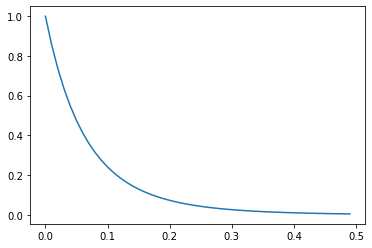

In [81]:
plt.plot([i/100 for i in range(50)], size_diff)

### Reflection error instead of rotation error

In [72]:
flip = ssi(B=np.array([1-e, 0, e, 0]))

  0%|          | 0/3499 [00:00<?, ?it/s]

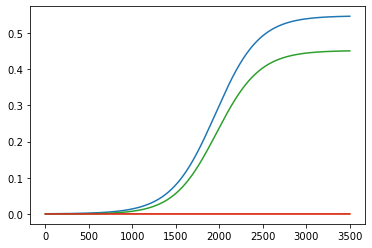

In [73]:
for i in flip.keys():
    plt.plot(range(T), flip.get(i), label=f"{i}")

## Degree Block 

In [90]:
m = 2
beta = 1/1000
k = 4
e = 0.1
size = 50
N = size**2
#T = int(log(N, R))\
T = 1500

In [91]:
degrees = np.random.pareto(2,N)
degrees = [int(i)+1  for i in degrees]

In [92]:
degree_counts = Counter(degrees)
deg_counts = Counter(degrees).most_common()

In [93]:
B = np.array([(1-e)**2, e*(1-e), e**2, e*(1-e)])

In [94]:
avgk = np.mean(degrees)

In [95]:
k_dist = np.array([degree_counts[k]/N for k in range(1, max(degrees)+1)])

In [106]:
counts = np.zeros((2**m, max(degrees), T))

# seed this randomly
seed = np.random.randint(N)
counts[0][degrees[seed]][0] = 1/degree_counts.get(degrees[seed])
print(degrees[seed])


    
for t in tqdm(range(1,T)):
    
    I = counts[:, :, t-1] 
    
    if t != 0:
        num_edges = (k-1)
    else:
        num_edges = k
    
    theta = np.array([sum(num_edges*p/N*I[x,k-1] for k,p in deg_counts)/avgk for x in range(counts.shape[0])])
    
    for x in range(counts.shape[0]):
        
        thetar = np.concatenate([theta[x:], theta[:x]]) # permuting the vector 
        
        for k,p in deg_counts:
    
            dik = beta * k * (1 - np.sum(I[:,k-1])) * np.matmul(B, thetar)
            
            counts[x][k-1][t] = counts[x][k-1][t-1] + dik
            

1


  0%|          | 0/1499 [00:00<?, ?it/s]

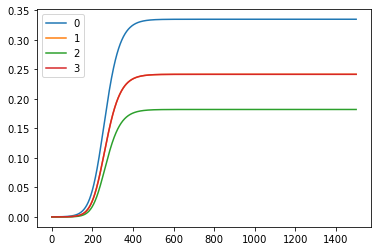

In [107]:
for x in range(4):
    plt.plot(range(T), [np.sum(k_dist*counts[x,:,t]) for t in range(T)], label='%d'%(x))
plt.legend()

## Simulations of Branching Processes

In [6]:
def int_to_bool_array(num, length=None):
    binary_str = bin(num)[2:]  # Convert number to binary string and remove '0b' prefix
    binary_array = np.array(list(map(int, binary_str)))  # Convert binary string to integer array
    
    if length is not None:
        padding = max(length - len(binary_array), 0)
        binary_array = np.pad(binary_array, (padding, 0), mode='constant')[:length]
    
    return binary_array.astype(bool)  # Convert integer array to boolean array

In [7]:
def bool_array_to_int(bool_array):
    binary_str = ''.join(map(str, bool_array.astype(int)))  # Convert boolean array to binary string
    return int(binary_str, 2)  # Convert binary string to integer

In [8]:
def channel(m, e, length=None):
    
    """
    :m: [int] some encoded message which is being passed through this channel 
    :e: [float] error probability of a single bit being flipped
    """
    
    if m > -1:
        m = int_to_bool_array(m, length)

        r = np.random.rand(len(m)) # each bit has probability (1-e) of staying 

        m[(r<=e)] = [not i for i in m[(r<=e)]]
    
    return m

In [9]:
k = 2
n = 1
layer = 0
e = 0.1

nodes = [[3]]

while not n > N:
    
    new_layer = list()
    
    for node in nodes[layer]:
        for _ in range(k):
            m = channel(node, e)
            new_layer.append(bool_array_to_int(m))
    nodes.append(new_layer)
    layer += 1
    n = k*len(nodes[layer])

In [10]:
np.unique(nodes[-1], return_counts=True)

(array([0, 1, 2, 3]), array([509, 501, 441, 597], dtype=int64))

In [11]:
branch_counts = {i: list() for i in range(4)}


for n in tqdm(nodes):
    temp = {i:0 for i in range(4)}
    v,c = np.unique(n, return_counts=True)
    z = zip(v,c)
    for pair in z:
        temp[pair[0]] = pair[1]
        
    for key in temp:
        branch_counts[key].append(temp[key])

  0%|          | 0/12 [00:00<?, ?it/s]

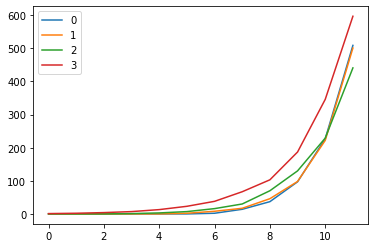

In [12]:
for i in range(4):
    plt.plot(range(len(nodes)), branch_counts.get(i), label=f"{i}")
    
plt.legend()

# Generalizing to m length messages

In [4]:
m = 3
e = 0.05

In [38]:
def poly_gen(m):
    
    if m <= 0:
        raise ValueError("The dimension of the cube must be a positive integer.")

    # Calculate the total number of vertices in the n-cube
    num_vertices = 2**m

    # Initialize an n x n matrix with all zeros
    adjacency_matrix = [[0] * num_vertices for _ in range(num_vertices)]

    # Iterate through all vertices
    for i in range(num_vertices):
        # Iterate through all dimensions
        for j in range(m):
            # Toggle the j-th bit to find the adjacent vertex
            neighbor = i ^ (1 << j)
            adjacency_matrix[i][neighbor] = 1

    return np.array(adjacency_matrix)

In [42]:
def ncube(m):
    
    selfloops = np.eye(2**m)*(1-e)
    polygon = poly_gen(m) * e
    
    return selfloops + polygon

In [ ]:
# single flip

  0%|          | 0/3499 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction Infected with Strain $x$ ($i_x$)')

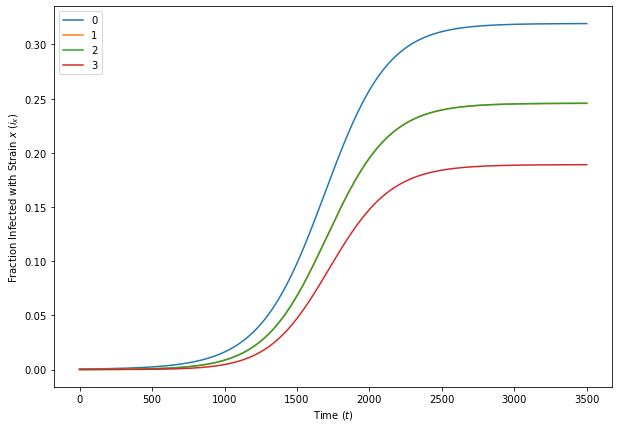

In [50]:
beta = 1/1000
k = 4
e = 0.15
size = 50
N = size**2
#T = int(log(N, R))\
T = 3500
m=2

B = ncube(m)

counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,2**m):
    
    counts[i].append(0)
    
for t in tqdm(range(1,T)):
    
    I = np.array([[counts.get(x)[-1]] for x in counts.keys()], dtype=object)
    
    new = np.zeros((2**m,1))
    
    for x in counts.keys():
        
        di = beta * k * (1 - np.sum(I)) * np.matmul(B[x,:], I)
        
        new[x,0] = di
    
    It = I+new
    for x in counts.keys():
        counts[x].append(It[x][0])

fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), counts.get(i), label=f"{i}")
             
plt.legend()

#plt.title(r'SI Model with Interaction, $e=5\%$')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Fraction Infected with Strain $x$ ($i_x$)')
#plt.savefig('SI_error_100.pdf')

  0%|          | 0/3499 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction Infected with Strain $x$ ($i_x$)')

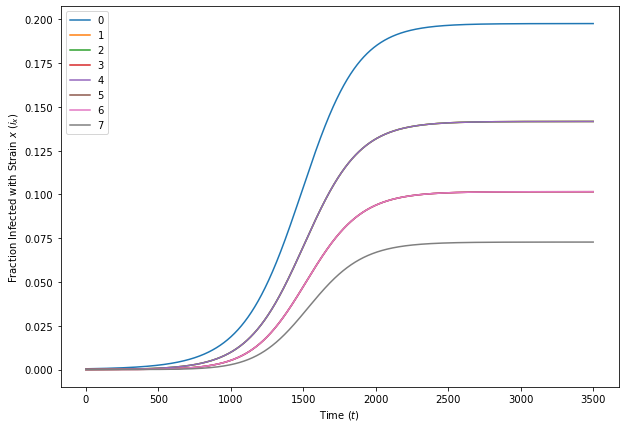

In [51]:
beta = 1/1000
k = 4
e = 0.15
size = 50
N = size**2
#T = int(log(N, R))\
T = 3500
m=3

B = ncube(m)

counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,2**m):
    
    counts[i].append(0)
    
for t in tqdm(range(1,T)):
    
    I = np.array([[counts.get(x)[-1]] for x in counts.keys()], dtype=object)
    
    new = np.zeros((2**m,1))
    
    for x in counts.keys():
        
        di = beta * k * (1 - np.sum(I)) * np.matmul(B[x,:], I)
        
        new[x,0] = di
    
    It = I+new
    for x in counts.keys():
        counts[x].append(It[x][0])

fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), counts.get(i), label=f"{i}")
             
plt.legend()

#plt.title(r'SI Model with Interaction, $e=5\%$')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Fraction Infected with Strain $x$ ($i_x$)')
#plt.savefig('SI_error_100.pdf')

  0%|          | 0/3499 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction Infected with Strain $x$ ($i_x$)')

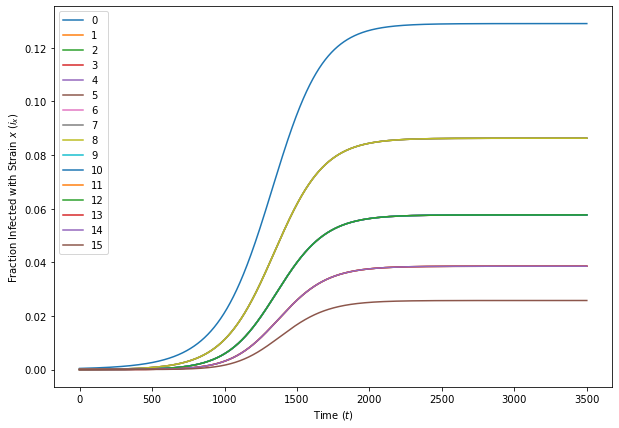

In [49]:
beta = 1/1000
k = 4
e = 0.15
size = 50
N = size**2
#T = int(log(N, R))\
T = 3500
m = 4

B = ncube(m)

counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,2**m):
    
    counts[i].append(0)
    
for t in tqdm(range(1,T)):
    
    I = np.array([[counts.get(x)[-1]] for x in counts.keys()], dtype=object)
    
    new = np.zeros((2**m,1))
    
    for x in counts.keys():
        
        di = beta * k * (1 - np.sum(I)) * np.matmul(B[x,:], I)
        
        new[x,0] = di
    
    It = I+new
    for x in counts.keys():
        counts[x].append(It[x][0])

fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), counts.get(i), label=f"{i}")
             
plt.legend()

#plt.title(r'SI Model with Interaction, $e=5\%$')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Fraction Infected with Strain $x$ ($i_x$)')
#plt.savefig('SI_error_100.pdf')

In [ ]:
# can we code this up for compounding error??
# need to change the 0s in the matrix to the appropriate values

# Bit Flip Error

In [137]:
B3 = np.array([[0,1,1,2,1,2,2,3],
               [1,0,2,1,2,1,3,2],
               [1,2,0,1,2,3,1,2],
               [2,1,1,0,3,2,2,1],
               [1,2,2,3,0,1,1,2],
               [2,1,3,2,1,0,2,1],
               [2,3,1,2,1,2,0,1],
               [3,2,2,1,2,1,1,0]])

M = np.zeros((8,8))

for i in range(8):
    for j in range(8):
        M[i,j] = e**B3[i,j] * (1-e)**(m-B3[i,j])

In [138]:
M

array([[0.614125, 0.108375, 0.108375, 0.019125, 0.108375, 0.019125,
        0.019125, 0.003375],
       [0.108375, 0.614125, 0.019125, 0.108375, 0.019125, 0.108375,
        0.003375, 0.019125],
       [0.108375, 0.019125, 0.614125, 0.108375, 0.019125, 0.003375,
        0.108375, 0.019125],
       [0.019125, 0.108375, 0.108375, 0.614125, 0.003375, 0.019125,
        0.019125, 0.108375],
       [0.108375, 0.019125, 0.019125, 0.003375, 0.614125, 0.108375,
        0.108375, 0.019125],
       [0.019125, 0.108375, 0.003375, 0.019125, 0.108375, 0.614125,
        0.019125, 0.108375],
       [0.019125, 0.003375, 0.108375, 0.019125, 0.108375, 0.019125,
        0.614125, 0.108375],
       [0.003375, 0.019125, 0.019125, 0.108375, 0.019125, 0.108375,
        0.108375, 0.614125]])

  0%|          | 0/3499 [00:00<?, ?it/s]

Text(0, 0.5, 'Fraction Infected with Strain $x$ ($i_x$)')

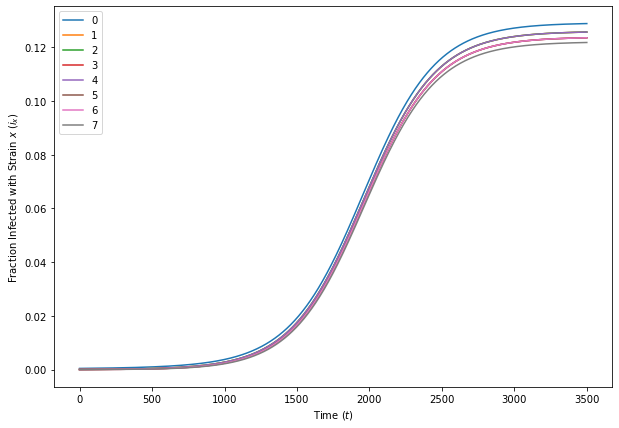

In [147]:
beta = 1/1000
k = 4
e = 0.3
size = 50
N = size**2
#T = int(log(N, R))\
T = 3500
m=3



M = np.zeros((8,8))

for i in range(8):
    for j in range(8):
        M[i,j] = e**B3[i,j] * (1-e)**(m-B3[i,j])

counts = defaultdict(list)

counts[0].append(1/N)

for i in range(1,2**m):
    
    counts[i].append(0)
    
for t in tqdm(range(1,T)):
    
    I = np.array([[counts.get(x)[-1]] for x in counts.keys()], dtype=object)
    
    new = np.zeros((2**m,1))
    
    for x in counts.keys():
        
        di = beta * k * (1 - np.sum(I)) * np.matmul(M[x,:], I)
        
        new[x,0] = di
    
    It = I+new
    for x in counts.keys():
        counts[x].append(It[x][0])

fig = plt.figure(figsize=(10,7))
for i in counts.keys():
    plt.plot(range(T), counts.get(i), label=f"{i}")
             
plt.legend()

#plt.title(r'SI Model with Interaction, $e=5\%$')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Fraction Infected with Strain $x$ ($i_x$)')
#plt.savefig('SI_error_100.pdf')

In [158]:
7 >> 1

3